In [1]:
import os
import sys
import argparse
import shlex
import subprocess

from scipy import sparse
from scipy.io import mmread
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import multiprocessing as mp
from datetime import datetime

import seaborn as sns
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D      
# from ete3 import Tree, TreeStyle, NodeStyle, TextFace, CircleFace, add_face_to_node

# connectness
import networkx as nx

_version = "v0.1"

In [2]:
import os
os.environ['QT_QPA_PLATFORM']='offscreen'

In [9]:
def get_cell_dis_dev(mat, v_prior, i, j):
    if i < j:
        return (abs(mat[i, :] - mat[j, :]) * v_prior).sum()
        # return (abs(mat[i, :] - mat[j, :]) * 1).sum()
    else:
        return 0

def get_distance(mat, n_core=64):
    cell_n, _v_n = mat.shape

    v_mean_af = mat.mean(0)
    v_prior = 1 - v_mean_af

    p = mp.Pool(n_core)
    results = p.starmap(get_cell_dis_dev, ((mat, v_prior, i, j) for i in range(cell_n) for j in range(cell_n) ))
    results = np.array(results).reshape(cell_n, cell_n)
#     # assign all element
    i_lower = np.tril_indices(cell_n, -1)
    results[i_lower] = results.T[i_lower]

    p.close()
    p.join()
    return results


def aggregate_distance_matrix_by_class(X, class_df, cls_n="clone"):
    # Get unique classes
    classes = class_df.iloc[:, 0].unique()
    # Initialize a dictionary to store the results
    results = {}
    # Iterate over each class as the target class
    for target_class in classes:
        # Get the nodes that belong to the target class
        target_nodes = class_df[class_df[cls_n] == target_class].index
        # Initialize a dictionary to count connections to each class
        connection_counts = {cls: 0 for cls in classes}
        total_connections = 0
        # Iterate over each node in the target class
        for node in target_nodes:
            # Get the connections of the current node
            connections = X[node]
            # Count connections to each class
            for connected_node in np.where(connections == 1)[0]:
                connected_class = class_df.loc[connected_node, cls_n]
                # print(target_class, connected_node, connected_class)
                connection_counts[connected_class] += 1
                total_connections += 1
        # Calculate the proportion of connections to each class
        proportions = {cls: (count / total_connections * 100 if total_connections > 0 else 0) for cls, count in connection_counts.items()}
        # Store the result for the target class
        results[target_class] = proportions
    # Convert the result dictionary to a DataFrame for a better presentation
    results_df = pd.DataFrame(results).T
    return results_df


def from_dist_to_graph(d, k_param=30, return_nx_graph=True):
    if not isinstance(d, np.ndarray):
        d = d.values

    n_cells = d.shape[0]
    knn_mat = np.zeros((n_cells, k_param), dtype=int)
    knd_mat = np.zeros((n_cells, k_param))

    # Find k nearest neighbors for each cell
    for i in range(n_cells):
        knn_indices = np.argsort(d[i, :])[:k_param]
        knn_mat[i, :] = knn_indices
        knd_mat[i, :] = d[i, knn_indices]

    nn_dist = knn_mat[:, :k_param]
    knn = nn_dist

    # Compute mutual k-nearest neighbors (MNN)
    knn2 = []
    for i in range(knn.shape[0]):
        xx = np.apply_along_axis(lambda x: i in x, 1, knn[knn[i, 1:], :])
        if np.sum(xx) > 0:
            temp_knn = np.concatenate(([knn[i, 0]], knn[i, 1:][xx]))
            temp_el = [[temp_knn[0], neighbor] for neighbor in temp_knn[1:]]
        # else:
        #     temp_el = [[knn[i, 0], knn[i, 1]]]
            knn2.extend(temp_el)

    el = np.array(knn2)
    graph = nx.Graph()
    graph.add_nodes_from(range(n_cells))
    graph.add_edges_from(el)

    mutual_knn = nx.to_numpy_array(graph, nodelist=range(n_cells))
    if return_nx_graph:
        return mutual_knn, graph
    else:
        return mutual_knn, _

def get_connectness(ps_map, clone_df, _OUTGROUP_ID, out_dir, k_param=30, clone_label_prefix="clone"):
    knn_mat, knn_graph = from_dist_to_graph(ps_map, k_param, return_nx_graph=True)
    X = knn_mat

    #clone_df add outgroup
    clone_df.loc[len(clone_df) + 1] = [_OUTGROUP_ID, _OUTGROUP_ID]
    #print(af_df.shape)
    #print(af_df.head())

    class_df = clone_df[["barcode", "clone"]].reset_index()[['clone']]
    results_df = aggregate_distance_matrix_by_class(X, class_df)

    results_df = results_df.drop(index=_OUTGROUP_ID)
    results_df = results_df.drop(columns=_OUTGROUP_ID)
    no = sorted(results_df.columns, key=lambda x: int(x[len(clone_label_prefix):]))
    tmp_df = results_df.loc[no, no]
    tmp_df = (tmp_df + tmp_df.T ) / 2
    g = sns.clustermap(tmp_df, annot=False, xticklabels=True, yticklabels=True, row_cluster=True, col_cluster=False, figsize=(8,6), z_score=0, cmap="vlag", center=0)
    plt.close()
    row_order = g.dendrogram_row.reordered_ind
    tmp_df_reordered = tmp_df.iloc[row_order, row_order]
    g = sns.clustermap(tmp_df_reordered, annot=False, xticklabels=True, yticklabels=True, row_cluster=False, col_cluster=False, figsize=(8,6), z_score=0, cmap="vlag", center=0)
    g.fig.suptitle("Clone in mtDNA lineage-tracing-based neighborhood", fontsize=15)
    g.ax_heatmap.set_xlabel("Clonal neighbors", fontsize=15)
    g.ax_heatmap.set_ylabel("Clons of query cells", fontsize=15)
    g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=14)  # Set x-axis label size
    g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=14) 
    _out_png_f = "%s/2_clone_connectness.png" % (out_dir)
    plt.savefig(_out_png_f, bbox_inches='tight')





def main_parser():
    parser = argparse.ArgumentParser(
        description="Run run_VCFPhlyo.py")
    # print version
    parser.add_argument('-v', '--version', action='version', version='VCFPhylo {}'.format(_version))
 
    parser.add_argument(
        "--ad_f",
        type=str,
        required=True,
        default=None,
        help="AD matrix file, in mtx format."
    )

    parser.add_argument(
        "--dp_f",
        type=str,
        required=True,
        default=None,
        help="DP matrix file, in mtx format."
    )

    parser.add_argument(
        "--c_f",
        type=str,
        required=True,
        default=None,
        help="cell name, each cell name per line"
    )

    parser.add_argument(
        "--v_f",
        type=str,
        required=True,
        default=None,
        help="variant name, each variant name name per line, in format of {POS}{REF}>{ALT}, i.e. 2040G>A"
    )



    parser.add_argument(
        "-o",
        "--output_dir",
        type=str,
        required=True,
        default=None,
        help="output_dir"
    )

    parser.add_argument(
        "--get_clone",
        action='store_true',
        help="output_dir"
    )

    parser.add_argument(
        "--only_check",
        action='store_true',
        help="only_check"
    )

    parser.add_argument(
        "--clone_n",
        type=int,
        required=False,
        default=0,
        help="estimated clone number, 0 for unknown"
    )

    parser.add_argument(
        "--clone_f",
        type=str,
        required=False,
        default=None,
        help="clone annotation file"
    )

    parser.add_argument(
        "--rapidNJ_p",
        type=str,
        required=False,
        default="rapidnj",
        help="rapidnj path, install from https://github.com/somme89/rapidNJ"
    )

    parser.add_argument(
        "--R_env_p",
        type=str,
        required=False,
        default="Rscript",
        help="Rscript path"
    )

    parser.add_argument(
        "--ref_fasta",
        type=str,
        required=False,
        default="",
        help="ref fasta"
    )

    parser.add_argument(
        "--clone_label_prefix",
        type=str,
        required=False,
        default="clone",
        help="clone label prefix"
    )

    parser.add_argument(
        "--min_dp",
        type=int,
        required=False,
        default=5,
        help="minimum read coverage for validating a SNP"
    )
    parser.add_argument(
        "--min_af",
        type=float,
        required=False,
        default=0.1,
        help="minimum allele frequency for validating a SNP"
    )
    return parser

# WRITE TO FASTA
def write_fasta(new_f, AD, DP, cell_id, var_id, VAF_absent = 0.05, VAF_present = 0.1, is_GT=False, GT=None):
    alphabet = {"A" : "A",
                "C" : "C",
                "G" : "G",
                "T" : "T",
                "AG" : "R",
                "CT" : "Y",
                "CG" : "S",
                "AT" : "W",
                "GT" : "K",
                "AC" : "M",
                "CGT" : "B",
                "AGT" : "D",
                "ACT" : "H",
                "ACG" : "V",
                "ACGT" : "N"}
    print(new_f)
    with open(new_f, "w+") as F:
        _vn, _cn = AD.shape

        for ci in range(_cn):
            F.write(">%s\n" % (cell_id[ci]))
            for vi in range(_vn):
                _, _p, _r, _a = var_id[vi].split("_")
                if not is_GT:
                    _ad, _dp = AD[vi,ci], DP[vi,ci]
                    _af = 0 if _dp <= 0 else _ad / _dp
                    _gt = _r
                    if _af > VAF_present:
                        _gt = _a
                    elif _af > VAF_absent:
                        # _gt = "N"
                        _tmp_c = _r + _a if _r < _a else _a + _r
                        _gt = alphabet[_tmp_c]
                else:
                    t_gt = GT[vi,ci]
                    if t_gt == "0/0":
                        _gt = _r
                    if t_gt == "0/1":
                        _tmp_c = _r + _a if _r < _a else _a + _r
                        _gt = alphabet[_tmp_c]
                    if t_gt == "1/1":
                        _gt = _a
                    # print(t_gt, _gt)
                F.write("%s" % (_gt))
            F.write("\n")

            
# WRITE TO CF #http://www.iqtree.org/doc/Polymorphism-Aware-Models
def write_cf(new_f, AD, DP, cell_id, var_id):
    with open(new_f, "w+") as F:
        _vn, _cn = AD.shape
        F.write("COUNTSFILE NPOP %s NSITES %s\n" % (_cn, _vn))
        F.write("CHROM POS %s\n" % (" ".join(cell_id)))
        
        for vi in range(_vn):
            _p, _r, _a = '', '', ''
            if "_" in var_id[vi]:
                _, _p, _r, _a = var_id[vi].split("_")
            else:
                _p, _r, _a = int(var_id[vi][:-3]), var_id[vi][-3], var_id[vi][-1]
            F.write("{} {} ".format("1", _p))
            for ci in range(_cn):
                _ad, _dp = AD[vi,ci], DP[vi,ci]
                cnt_t = [0,0,0,0]
                acgt_m = {"A": 0, "C":1, "G":2, "T":3}
                cnt_t[acgt_m[_a.upper()]] += int(_ad)
                cnt_t[acgt_m[_r.upper()]] += (int(_dp)-int(_ad))
                
                F.write(" %s" % (",".join([str(_k) for _k in cnt_t])))
            F.write("\n")

# WRITE TO FASTA
def write_fasta_af(new_f, AF, cell_id, var_id, VAF_absent = 0.05, VAF_present = 0.1, is_GT=False, GT=None):
    alphabet = {"A" : "A",
                "C" : "C",
                "G" : "G",
                "T" : "T",
                "AG" : "R",
                "CT" : "Y",
                "CG" : "S",
                "AT" : "W",
                "GT" : "K",
                "AC" : "M",
                "CGT" : "B",
                "AGT" : "D",
                "ACT" : "H",
                "ACG" : "V",
                "ACGT" : "N"}
    print(new_f)
    with open(new_f, "w+") as F:
        _vn, _cn = AF.shape

        for ci in range(_cn):
            F.write(">%s\n" % (cell_id[ci]))
            for vi in range(_vn):
                #_, _p, _r, _a = var_id[vi].split("_")
                _p, _r, _a = int(var_id[vi][:-3]), var_id[vi][-3], var_id[vi][-1]
                _af = AF.loc[var_id[vi], cell_id[ci]]
                _gt = _r
                if _af > VAF_present:
                    _gt = _a
                elif _af > VAF_absent:
                    # _gt = "N"
                    _tmp_c = _r + _a if _r < _a else _a + _r
                    _gt = alphabet[_tmp_c]
                F.write("%s" % (_gt))
            F.write("\n")

# optional, get clone info. from VAF
def run_get_clone(AD, DP, mtSNP_ids, _barcode, out_dir, clone_n=0, only_check=0, clone_label_prefix=""):
    import vireoSNP
    from vireoSNP import BinomMixtureVB
    print(vireoSNP.__file__)

    print("run get clone")
    # if unknown clone size
    _max_clone = 17
    _n_init = 50
    _random_see = 42
    if clone_n == 0:
        n_clone_list = np.arange(2, _max_clone)
	# n_clone_list = np.arange(2, 20)
        _ELBO_mat = []
        K_map = {}
        for k in n_clone_list:
            print("check clone size %s" % (k), end='\r')
            _model = BinomMixtureVB(n_var=AD.shape[0], n_cell=AD.shape[1], n_donor=k)
            _model.fit(AD, DP, min_iter=30, n_init=_n_init, random_seed=_random_see, verbose=False)
            K_map["K%s" % k] = _model.ID_prob.argmax(1)
            _ELBO_mat.append(_model.ELBO_inits)

        plt.plot(np.arange(1, len(n_clone_list)+1), np.max(_ELBO_mat, axis=1))
        plt.boxplot(_ELBO_mat)
        plt.xticks(np.arange(1, len(n_clone_list)+1), n_clone_list)
        plt.ylabel("ELBO")
        plt.xlabel("n_clones")
        #plt.show()

        _out_png_f = "%s/0_clone_elbo.png" % (out_dir)
        plt.savefig(_out_png_f, bbox_inches='tight')

        if only_check == 1:
            return


        clone_n = np.arange(1, len(n_clone_list)+1)[np.argmax(np.mean(_ELBO_mat, axis=1))] + 1
        print("selected clone size of {}".format(clone_n))

    _n_donor = clone_n
    _model = BinomMixtureVB(n_var=AD.shape[0], n_cell=AD.shape[1], n_donor=_n_donor)
    #_model.fit(AD, DP, min_iter=30, n_init=50, random_seed=42)
    _model.fit(AD, DP, min_iter=30, n_init=_n_init, random_seed=_random_see)

    fig = plt.figure(figsize=(11, 4))
    plt.subplot(1, 2, 1)
    plt.hist(_model.ELBO_inits)
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    plt.plot(_model.ELBO_iters)
    plt.xlabel("Iterations")
    plt.ylabel("ELBO in a single initialization")

    plt.tight_layout()

    #plt.show()
    _out_png_f = "%s/0_clone_assignment_0.png" % (out_dir)
    plt.savefig(_out_png_f, bbox_inches='tight')


    raw_col = cm.get_cmap('pink_r', 200)
    new_col = np.vstack((raw_col(np.linspace(0, 0.7, 10)),
                             raw_col(np.linspace(0.7, 1, 90))))
    segpink = ListedColormap(new_col, name='segpink')

    from vireoSNP.plot import heat_matrix

    fig = plt.figure(figsize=(7, 4), dpi=100)
    plt.subplot(1, 2, 1)
    im = heat_matrix(_model.ID_prob, cmap="Blues", alpha=0.8,
                             display_value=False, row_sort=True)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title("Assignment probability")
    plt.xlabel("Clone")
    plt.ylabel("%d cells" %(_model.n_cell))
    plt.xticks(range(_model.n_donor))


    plt.subplot(1, 2, 2)
    im = heat_matrix(_model.beta_mu, cmap=segpink, alpha=0.8,
                             display_value=False, row_sort=True)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title("Mean allelic ratio")
    plt.xlabel("Clone")
    plt.ylabel("%d SNPs" %(_model.n_var))
    plt.xticks(range(_model.n_donor))

    plt.tight_layout()
    # plt.show()
    _out_png_f = "%s/0_clone_assignment_1.png" % (out_dir)
    plt.savefig(_out_png_f, bbox_inches='tight')

    # label clones
    cell_label = np.array(['%s%d' % (clone_label_prefix, x) for x in np.argmax(_model.ID_prob, axis=1)])
    id_uniq = np.unique(cell_label)
    # id_uniq = sorted(id_uniq, key=lambda x:int(x.split('e')[1]))
    id_uniq = sorted(id_uniq, key=lambda x:int(x[len(clone_label_prefix):]))
    
    # sort variants
    clone_ids = np.argmax(_model.ID_prob, axis=1)
    AF_mat = AD.A/(DP.A + 0.0001)
    var_idx = np.argsort(AF_mat @ (5**(max(clone_ids) - clone_ids)))[::-1]

    global _cmap, _colors
    var_idx = np.argsort([int(x[:-3]) for x in np.array(mtSNP_ids)])

    # g = vireoSNP.plot.anno_heat((AD/DP)[var_idx, :], col_anno=cell_label, col_order_ids=id_uniq, 
    g = anno_heat((AD/DP)[var_idx, :], col_anno=cell_label, col_order_ids=id_uniq, 
                            cmap=_cmap, yticklabels=np.array(mtSNP_ids)[var_idx], _color = _colors)
    g.fig.suptitle("Allele frequency distribution of %s variants in %s cells" % (AD.shape), fontsize=18)
    _out_png_f = "%s/0_clone_assignment_2.png" % (out_dir)
    plt.savefig(_out_png_f, bbox_inches='tight')


    tmp_df = pd.DataFrame(AF_mat, index=mtSNP_ids).stack().reset_index()
    cell_label = pd.DataFrame(cell_label, columns=["annotation"])
    tmp_df = tmp_df.merge(cell_label, left_on='level_1', right_index=True, how='left')
    tmp_df['cell_label'] = tmp_df['annotation']
    tmp_df = tmp_df.groupby(['level_0', 'cell_label'])[0].mean().unstack()
    AF_m_df = tmp_df.copy()

    tmp_df = pd.DataFrame(AD.A, index=mtSNP_ids).stack().reset_index()
    cell_label = pd.DataFrame(cell_label, columns=["annotation"])
    tmp_df = tmp_df.merge(cell_label, left_on='level_1', right_index=True, how='left')
    tmp_df['cell_label'] = tmp_df['annotation']
    tmp_df = tmp_df.groupby(['level_0', 'cell_label'])[0].mean().unstack()
    AD_m_df = tmp_df.copy()

    tmp_df = pd.DataFrame(DP.A, index=mtSNP_ids).stack().reset_index()
    cell_label = pd.DataFrame(cell_label, columns=["annotation"])
    tmp_df = tmp_df.merge(cell_label, left_on='level_1', right_index=True, how='left')
    tmp_df['cell_label'] = tmp_df['annotation']
    tmp_df = tmp_df.groupby(['level_0', 'cell_label'])[0].mean().unstack()
    DP_m_df = tmp_df.copy()
    
    _cell_label = AF_m_df.columns.values
    id_uniq = np.unique(_cell_label)
    # id_uniq = sorted(id_uniq, key=lambda x:int(x.split('e')[1]))
    id_uniq = sorted(id_uniq, key=lambda x:int(x[len(clone_label_prefix):]))

    _af_cf = 0.6
    raw_col = cm.get_cmap('Blues', 200)
    raw_col = cm.get_cmap('pink_r', 200)
    new_col = np.vstack((raw_col(np.linspace(0, _af_cf, 10)),
                         raw_col(np.linspace(_af_cf, 1, 90))))
    __cmap = ListedColormap(new_col)

    # id_uniq
    row_ids = sorted(AF_m_df.index, key=lambda x:int(x[:-3]))

    # g = vireoSNP.plot.anno_heat(AF_m_df.loc[row_ids].to_numpy(), col_order_ids=id_uniq, col_anno=_cell_label, 
    g = anno_heat(AF_m_df.loc[row_ids].to_numpy(), col_order_ids=id_uniq, col_anno=_cell_label, 
                  cmap=__cmap, _color=_colors, yticklabels=AF_m_df.loc[row_ids].index, figsize=(8,8))

    g.ax_row_dendrogram.set_visible(False)
    g.fig.suptitle("Mean Allele frequency distribution of %s variants in each group" % (AF_mat.shape[0]), fontsize=18)
    _out_png_f = "%s/0_clone_assignment_3.png" % (out_dir)
    plt.savefig(_out_png_f, bbox_inches='tight')

    from collections import Counter
    ct = Counter(cell_label)

    pd.DataFrame(ct, index=['count'])


    clone_df = pd.DataFrame(_barcode, columns=["barcode"])
    clone_df['clone'] = cell_label
    clone_df.to_csv(out_dir+ "/clone.csv", header=True, index=False)

    return AF_m_df, AD_m_df, DP_m_df

vireo_colors = np.array(['#4796d7', '#f79e54', '#79a702', '#df5858', '#556cab',
                         '#de7a1f', '#ffda5c', '#4b595c', '#6ab186', '#bddbcf',
                         '#daad58', '#488a99', '#f79b78', '#ffba00', '#03AED2', '#68D2E8', '#FEEFAD', '#D10363', '#FFE8C5', '#FFC96F', '#006769', '#344C64'])
def anno_heat(X, row_anno=None, col_anno=None,
              row_order_ids=None, col_order_ids=None,
              xticklabels=False, yticklabels=False,
              row_cluster=False, col_cluster=False,  _color= [],
              **kwargs):
    """
    Heatmap with column or row annotations. Based on seaborn.clustermap()
    Row or column will be ordered by the annotation group.

    Note, haven't tested if input both row_anno and col_anno.
    """
    # global _colors
    # vireo_colors = _colors[:]
    if len(_color) != 0:
        global vireo_colors
        vireo_colors = _color[:]

    import seaborn as sns

    # prepare row annotation
    if row_anno is not None:
        if row_order_ids is None:
            row_order_ids = list(np.unique(row_anno))
        else:
            row_order_ids = [x for x in row_order_ids]
        row_num = np.array([row_order_ids.index(x) for x in row_anno])

        dot_row = np.array(np.nansum(X, axis=1)).reshape(-1)
        idx_row = np.argsort(row_num * 2**X.shape[1])# + dot_row / dot_row.max())

        row_colors = vireo_colors[row_num][idx_row]
    else:
        row_colors = None
        row_order_ids = []
        idx_row = range(X.shape[0])

    # prepare col annotation
    if col_anno is not None:
        if col_order_ids is None:
            col_order_ids = list(np.unique(col_order_ids))
        else:
            col_order_ids = [x for x in col_order_ids]
        col_num = np.array([col_order_ids.index(x) for x in col_anno])

        dot_col = np.array(np.nansum(X, axis=0)).reshape(-1)
        idx_col = np.argsort(col_num * 2**X.shape[0])# + dot_row / dot_row.max())
        
        col_colors = vireo_colors[col_num][idx_col]
    else:
        col_colors = None
        col_order_ids = []
        idx_col = range(X.shape[1])

    ## plot with seaborn clustermap
    with sns.plotting_context(context="notebook", font_scale=1.4):
        g = sns.clustermap(X[idx_row, :][:, idx_col],
                       row_colors=row_colors, col_colors=col_colors,
                       col_cluster=col_cluster, row_cluster=row_cluster,
                       xticklabels=xticklabels, yticklabels=yticklabels,
                       **kwargs)

        if row_anno is not None:
            for i in range(len(row_order_ids)):
                g.ax_row_dendrogram.bar(0, 0, color=vireo_colors[i],
                                        label=row_order_ids[i], linewidth=0)
            g.ax_row_dendrogram.legend(loc="center", ncol=1, title="")
    
        if col_anno is not None:
            for i in range(len(col_order_ids)):
                g.ax_col_dendrogram.bar(0, 0, color=vireo_colors[i],
                                        label=col_order_ids[i], linewidth=0)
            g.ax_col_dendrogram.legend(loc="center", ncol=6, title="")
    
        g.cax.set_position([1.01, .2, .03, .45])
    
        return g

def get_outgroup(tree_o, tree_n, _OUTGROUP_ID="outgcell"):
    t = Tree(tree_o, format=1)
    # _OUTGROUP_ID = "outgcell"
    _outgroup_n = None
    for n in t.get_leaves():
        _n = n.name.replace("'", "")
        n.name = _n
        if _n == _OUTGROUP_ID:
            t.set_outgroup(n)
            _outgroup_n = n
            print('found outgroup')
    for node in t.iter_descendants():
        if node.dist < 0:
            node.dist = 0
    t.write(format=1, outfile=tree_n)
    print("marked outgroup cell")


# from itertools import chain
# import math

# from matplotlib.collections import LineCollection
# from matplotlib import markers
# from matplotlib.path import Path


In [4]:
from argparse import Namespace

# # d7
# _base_d = '/autofs/bal31/jhsu/home/projects/sc/data/hemo_paper_larry/larry-maester-d7/maester/4_mquad/'

#d4
_base_d = '/autofs/bal31/jhsu/home/projects/sc/data/hemo_paper_larry/larry-maester-d4/maester/'

_d = {'ad_f': '%s/passed_ad.mtx' % (_base_d), 
      'dp_f': '%s/passed_dp.mtx' % (_base_d), 
      'c_f': '%s//cellSNP.samples.tsv' % (_base_d), 
      'v_f': '%s/passed_variant_names.txt' % (_base_d), 
      'output_dir': '%s/tree_out' % (_base_d), 
      'get_clone': True, 'only_check': False, 'clone_n': 4, 'clone_f': None, 
      'min_dp': 5, 'min_af': 0.1,
      }

args = Namespace(**_d)
args.clone_n = 3
args.clone_label_prefix = "clone_A"

# args.clone_n = 4
# args.clone_label_prefix = "clone_B"
print(args)

Namespace(ad_f='/autofs/bal31/jhsu/home/projects/sc/data/hemo_paper_larry/larry-maester-d4/maester//passed_ad.mtx', dp_f='/autofs/bal31/jhsu/home/projects/sc/data/hemo_paper_larry/larry-maester-d4/maester//passed_dp.mtx', c_f='/autofs/bal31/jhsu/home/projects/sc/data/hemo_paper_larry/larry-maester-d4/maester///cellSNP.samples.tsv', v_f='/autofs/bal31/jhsu/home/projects/sc/data/hemo_paper_larry/larry-maester-d4/maester//passed_variant_names.txt', output_dir='/autofs/bal31/jhsu/home/projects/sc/data/hemo_paper_larry/larry-maester-d4/maester//tree_out', get_clone=True, only_check=False, clone_n=3, clone_f=None, min_dp=5, min_af=0.1, clone_label_prefix='clone_A')


In [5]:
global _cmap, _colors
_af_cf = 0.7
raw_col = cm.get_cmap('Blues', 200)
raw_col = cm.get_cmap('pink_r', 200)
new_col = np.vstack((raw_col(np.linspace(0, _af_cf, 10)), raw_col(np.linspace(_af_cf, 1, 90))))
_cmap = ListedColormap(new_col)

_colors = np.array([
    "blue",
    "yellow",
    "purple",
    "green",
    "orange",
    "red",
    "pink",
    "brown",
    "cyan",
    "magenta",
    "lime",
    "olive",
    "teal",
    "navy",
    "gold",
    "maroon",
    "aqua",
    "silver",
])

_colors = np.array(['#4796d7', '#f79e54', '#79a702', '#df5858', '#556cab',
                         '#de7a1f', '#ffda5c', '#4b595c', '#6ab186', '#bddbcf',
                         '#daad58', '#488a99', '#f79b78', '#ffba00', '#03AED2', '#68D2E8', '#FEEFAD', '#D10363', '#FFE8C5', '#FFC96F', '#006769', '#344C64'])

_OUTGROUP_ID = 'Outgroup'

global args

# parser = main_parser()

# args = parser.parse_args()

ad_f = args.ad_f
dp_f = args.dp_f
v_f = args.v_f
c_f= args.c_f
out_dir = args.output_dir
clone_n= args.clone_n
clone_label_prefix = args.clone_label_prefix

if not os.path.exists(out_dir):
    os.makedirs(os.path.abspath(out_dir))
print("output at {}".format(out_dir))

w_out_dir = "{}/work".format(out_dir)
if not os.path.exists(w_out_dir):
    os.makedirs(os.path.abspath(w_out_dir))


# read_data
AD = mmread(ad_f).tocsc()
DP = mmread(dp_f).tocsc()

mtSNP_ids = np.genfromtxt(v_f, dtype='str')

_barcode = np.genfromtxt(c_f, dtype='str')
all_bar_v = [i.split('-1')[0] for i in _barcode]


print("loaded files")
print("AD {}, DP {}, variant {}, cell {}".format(AD.shape, DP.shape, len(mtSNP_ids), len(_barcode)))

d_AD = AD.todense().astype(float)
d_DP = DP.todense().astype(float)

m = d_DP!=0
cell_AF = np.zeros_like(d_DP)
np.place(cell_AF, m, d_AD[m]/d_DP[m])
af_df = pd.DataFrame(cell_AF, columns=all_bar_v)
af_df.index = mtSNP_ids

snp_p_cell = (af_df > 0.05).mean(1) * 100
e_high_snp_p = 95
e_high_p_snp = snp_p_cell[snp_p_cell > e_high_snp_p].index.values.tolist()
high_snp_p = 80
high_p_snp = snp_p_cell[snp_p_cell > high_snp_p].index.values.tolist()
low_snp_p = 2
low_p_snp = snp_p_cell[snp_p_cell < low_snp_p].index.values.tolist()
safe_s = {'G>A', 'T>C', 'C>T', 'A>G', 'G>C'}
filter_p_snp = low_p_snp + high_p_snp
filter_p_snp = [i for i in filter_p_snp if i[-3:] not in safe_s]
filter_p_snp = filter_p_snp + e_high_p_snp
i_mtSNP_ids = [_i for _i, i in enumerate(mtSNP_ids) if i not in filter_p_snp]
print("filtered:")
print("extremly high propersion %s%%:" % (e_high_snp_p), e_high_p_snp[:10])
print("high propersion %s%%:" % (high_snp_p), high_p_snp[:10])
print("low propersion %s%%:" % (low_snp_p), low_p_snp[:10])
#print("filtered snp {}".format(high_p_snp))
#print(mtSNP_ids, high_p_snp)
#return 
# print(len(i_mtSNP_ids))
AD = AD[i_mtSNP_ids,:]
DP = DP[i_mtSNP_ids,:]
mtSNP_ids = mtSNP_ids[i_mtSNP_ids]
print("filtered high proportion snp, remains {}".format(len(mtSNP_ids)))
print(mtSNP_ids)


/tmp/ipykernel_2016772/857797232.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  raw_col = cm.get_cmap('Blues', 200)
/tmp/ipykernel_2016772/857797232.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  raw_col = cm.get_cmap('pink_r', 200)


output at /autofs/bal31/jhsu/home/projects/sc/data/hemo_paper_larry/larry-maester-d4/maester//tree_out
loaded files
AD (45, 5923), DP (45, 5923), variant 45, cell 5923
filtered:
extremly high propersion 95%: ['2617A>T', '9205T>A', '8597T>G', '8594T>G', '5147A>G']
high propersion 80%: ['2617A>T', '9205T>A', '8597T>G', '3232T>C', '8594T>G', '5147A>G', '8618T>G', '9204A>G', '8598T>G', '6970T>G']
low propersion 2%: ['7896G>A', '3019G>A', '3068G>A', '3085A>G', '2349G>A', '9025G>A', '9860C>A', '2071T>A', '2317G>A']
filtered high proportion snp, remains 35
['7402C>T' '7896G>A' '7116C>T' '2501C>A' '2502C>A' '6300G>A' '15016C>A'
 '3019G>A' '3068G>A' '6322G>C' '3085A>G' '3955G>A' '1526T>A' '1525C>A'
 '6323A>C' '6324G>A' '6321G>A' '1522T>A' '2349G>A' '1380G>A' '9025G>A'
 '1521T>A' '3232T>C' '12136T>G' '2352T>A' '8576T>G' '1123C>A' '13037C>T'
 '2507A>T' '9204A>G' '12139A>G' '8271A>T' '2317G>A' '6699G>A' '8087T>G']


/autofs/bal31/jhsu/home/_env/anaconda3/envs/scanpy/lib/python3.12/site-packages/vireoSNP/__init__.py
run get clone


/tmp/ipykernel_2016772/1239977008.py:427: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  raw_col = cm.get_cmap('pink_r', 200)
/tmp/ipykernel_2016772/1239977008.py:508: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  raw_col = cm.get_cmap('Blues', 200)
/tmp/ipykernel_2016772/1239977008.py:509: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  raw_col = cm.get_cmap('pink_r', 200)


assigned clone at /autofs/bal31/jhsu/home/projects/sc/data/hemo_paper_larry/larry-maester-d4/maester//tree_out/clone.csv
/autofs/bal31/jhsu/home/projects/sc/data/hemo_paper_larry/larry-maester-d4/maester//tree_out/0_clone_mean_af.fa


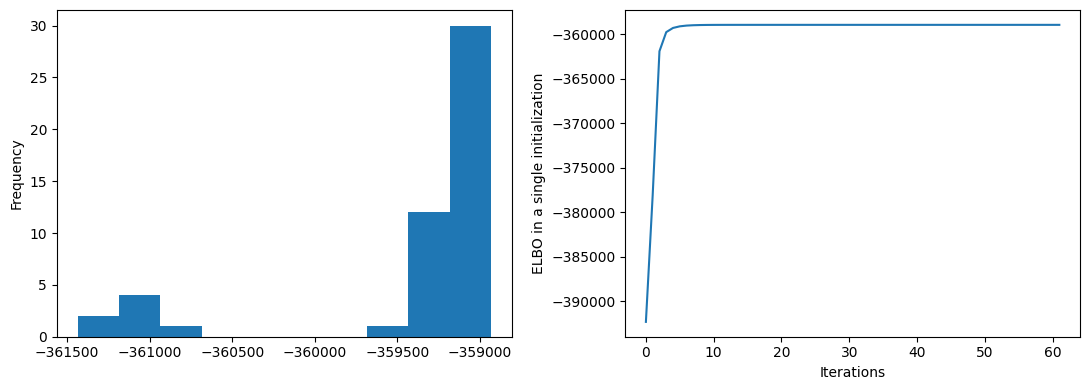

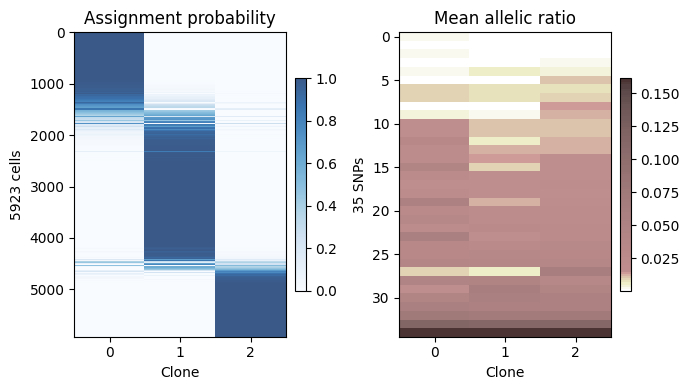

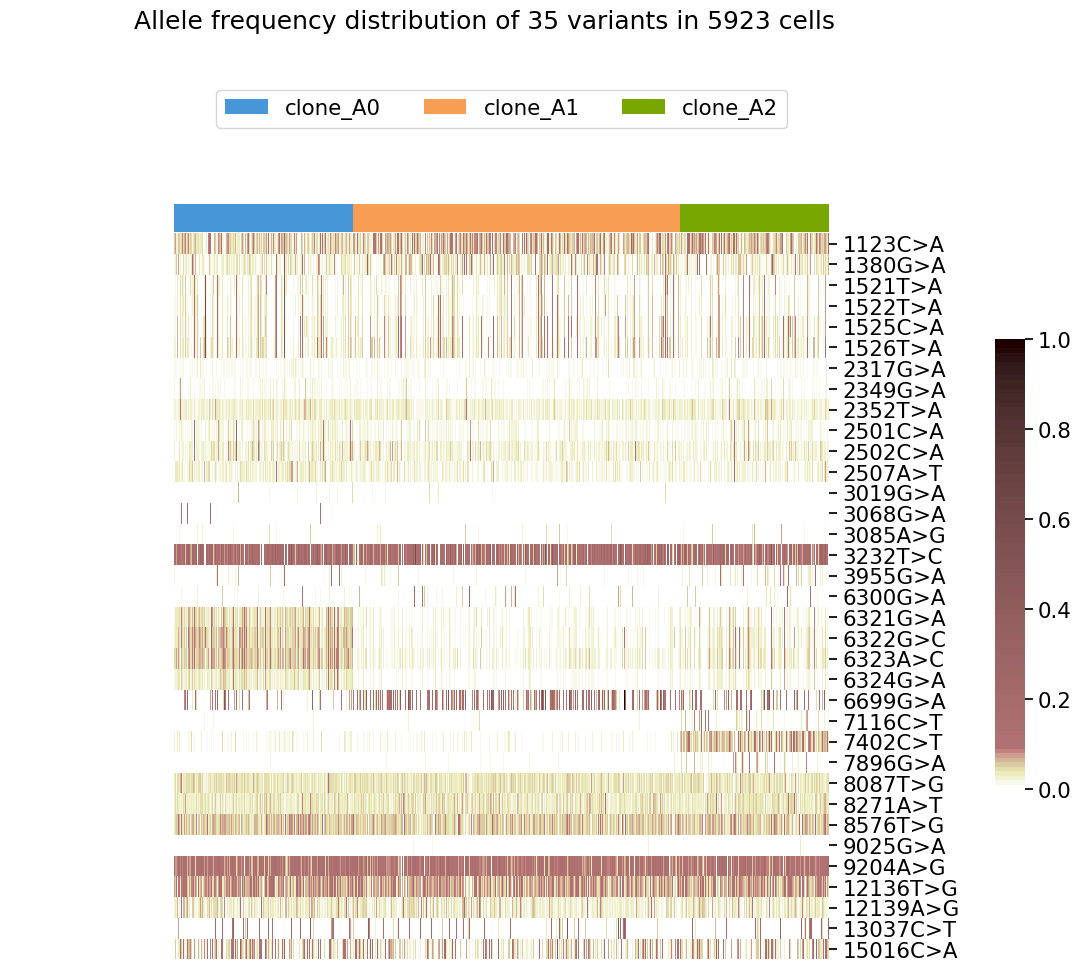

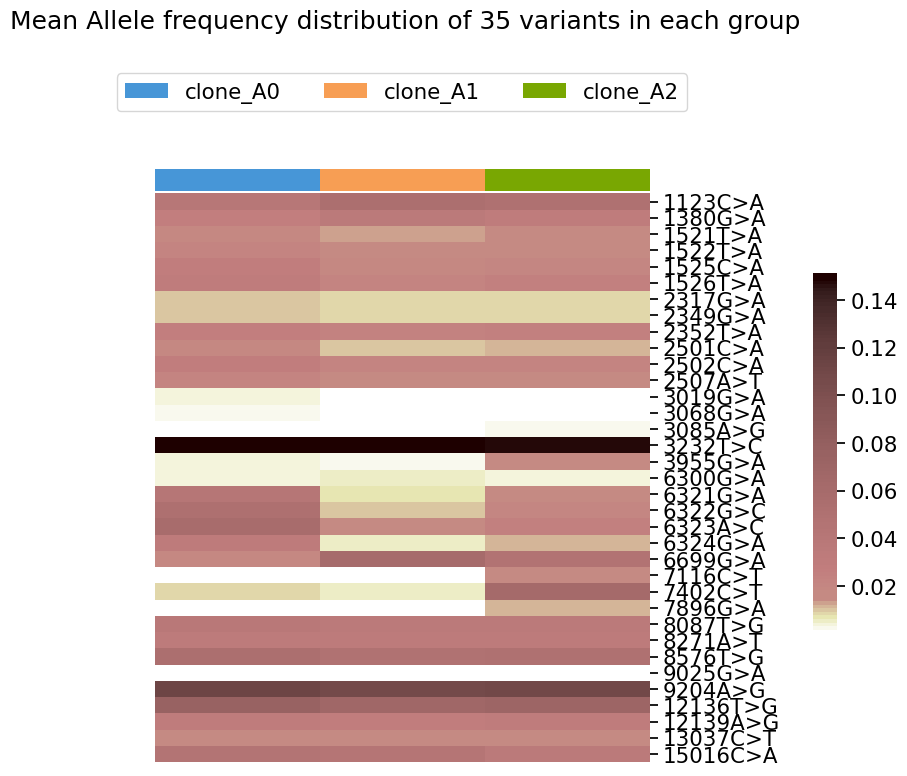

In [10]:
if args.only_check:
    run_get_clone(AD, DP, mtSNP_ids, all_bar_v, out_dir, clone_n=clone_n, only_check=1)
    print('done')

# get clone info. via vieroSNP
clone_m_df = None
if args.get_clone:
    AF_m_df, AD_m_df, DP_m_df = run_get_clone(AD, DP, mtSNP_ids, all_bar_v, out_dir, clone_n=clone_n, clone_label_prefix=clone_label_prefix)
    print("assigned clone at {}/clone.csv".format(out_dir))
    
    all_clone_id = AF_m_df.columns.to_list()

    # generate clone mean AF tree
    # add outgroup
    AF_m_df[_OUTGROUP_ID] = np.zeros(AF_m_df.shape[0])
    _out_clone_mean_f = "%s/0_clone_mean_af.csv" % (out_dir)
    AF_m_df.to_csv(_out_clone_mean_f, header=True)

    # write to fasta
    ofa_f = "%s/0_clone_mean_af.fa" % (out_dir)
    write_fasta_af(ofa_f, AF_m_df, cell_id=AF_m_df.columns.to_list(), var_id=AF_m_df.index.to_list(), VAF_absent = 0.001, VAF_present = 0.01, is_GT=False, GT=None)
    
    ocf_f = "%s/0_clone_mean.cf" % (out_dir)
    AD_m_df[_OUTGROUP_ID] = np.zeros(AD_m_df.shape[0])
    DP_m_df[_OUTGROUP_ID] = np.ones(DP_m_df.shape[0]) * 100
    AD_m_df = AD_m_df * 3
    # DP_m_df = DP_m_df * 2
    write_cf(ocf_f, AD_m_df.values, DP_m_df.values, cell_id=AD_m_df.columns.to_list(),var_id=AD_m_df.index.to_list())
    
    # # iqtree
    # iq_path = '/autofs/bal31/jhsu/home/projects/sc/tools/iqtree-1.6.12-Linux/bin/iqtree'
    # # _cmd = [iq_path, "-s", ofa_f, "-st", "DNA",  "-o", _OUTGROUP_ID , "-seed", "42", "-pre", "-quiet", w_out_dir + "/out_clone_m"]
    # _cmd = [iq_path, "-s", ocf_f, "-o", _OUTGROUP_ID , "-m", "HKY+P", "-seed", "42", "-quiet", "-redo", "-pre", w_out_dir + "/out_clone_m"]
    # subprocess.run(_cmd)


In [11]:
all_clone_id

['clone_A0', 'clone_A1', 'clone_A2']

In [12]:
# get df
AD = AD.todense().astype(float)
DP = DP.todense().astype(float)
mtSNP_ids = ['%s_%s_%s_%s' % ("chrM", i[:-3], i[-3], i[-1]) for i in mtSNP_ids]

AD_df = pd.DataFrame(AD, columns=all_bar_v, dtype=np.int64).set_index([pd.Index(mtSNP_ids)])
DP_df = pd.DataFrame(DP, columns=all_bar_v, dtype=np.int64).set_index([pd.Index(mtSNP_ids)])

m = DP!=0
cell_AF = np.zeros_like(AD)
np.place(cell_AF, m, AD[m]/DP[m])

af_df = pd.DataFrame(cell_AF, columns=all_bar_v)
af_df.index = mtSNP_ids
af_df.to_csv(out_dir + "/clone_af.csv", sep="\t", header=True, index=True)
#af_df.shape
#print(af_df.head())

# filtering cells
#min_dp = 5
#min_af = 0.1
min_dp = args.min_dp
min_af = args.min_af

min_dp = 2
min_af = 0.05

min_dp = 2
min_af = 0

filter_bc = np.array(AD_df.columns.values)[((DP_df >= min_dp) & (af_df >= min_af)).any()]
print("filter cell without any variants with DP>=%s and AF >=%s\noriginal: %s, after filering: %s" % (min_dp, min_af, af_df.shape[1], len(filter_bc)))
#run_filter_cells(AD, DP, mtSNP_ids, _barcode, out_dir)

tar_bc = filter_bc
new_AD_df = AD_df[tar_bc]
new_AD_df.to_csv(w_out_dir + "/ad_filtered.tsv", sep='\t', header=True, index=True)

new_DP_df = DP_df[tar_bc]
new_DP_df.to_csv(w_out_dir + "/dp_filtered.tsv", sep='\t', header=True, index=True)

af_df = af_df[tar_bc]



# add outgroup
af_df[_OUTGROUP_ID] = np.zeros(len(af_df))
new_AD_df[_OUTGROUP_ID] = np.zeros(len(new_AD_df))
#new_DP_df[_OUTGROUP_ID] = np.zeros(len(new_DP_df))
new_DP_df[_OUTGROUP_ID] = np.ones(len(new_DP_df))
new_AD_df.to_csv(w_out_dir + "/ad_filtered_og.tsv", sep='\t', header=True, index=True)
new_DP_df.to_csv(w_out_dir + "/dp_filtered_og.tsv", sep='\t', header=True, index=True)
af_df.to_csv(w_out_dir + "/af_filtered_og.tsv", sep='\t', header=True, index=True)


filter cell without any variants with DP>=2 and AF >=0
original: 5923, after filering: 5923


In [13]:
# get cell-cell distance
start_time = datetime.now()
# cell * variants
tar_m = np.array(af_df).T
ps_map = get_distance(tar_m)
end_time = datetime.now()

print('Computed cell-cell distance. (in {}s)'.format(end_time - start_time))

# write to distance phylip
dis_f = w_out_dir + "/tree_0.dis.phylip"

tar_m = ps_map
tar_id = [i for i in af_df.columns.values]
with open(dis_f, 'w') as F:
    tar_m_s = tar_m.shape[0]
    F.write("\t%s\n" % (tar_m_s))
    for i in range(tar_m_s):
        F.write(tar_id[i])
        F.write("\t%s\n" % ("\t".join(["%.6f" % (j) for j in tar_m[i, :]])))

Computed cell-cell distance. (in 0:00:46.804755s)


In [16]:
# subtree construction
clone_df = pd.read_csv(out_dir + "/clone.csv", header=0)
clone_df.head()

,barcode,clone
0,AAACCCACAAGACCTT,clone_A2
1,AAACCCACATCGCTGG,clone_A0
2,AAACCCAGTCAGGTAG,clone_A1
3,AAACCCAGTCGTCAGC,clone_A0
4,AAACCCATCAAACCTG,clone_A1


In [17]:
ps_map.shape

(5924, 5924)

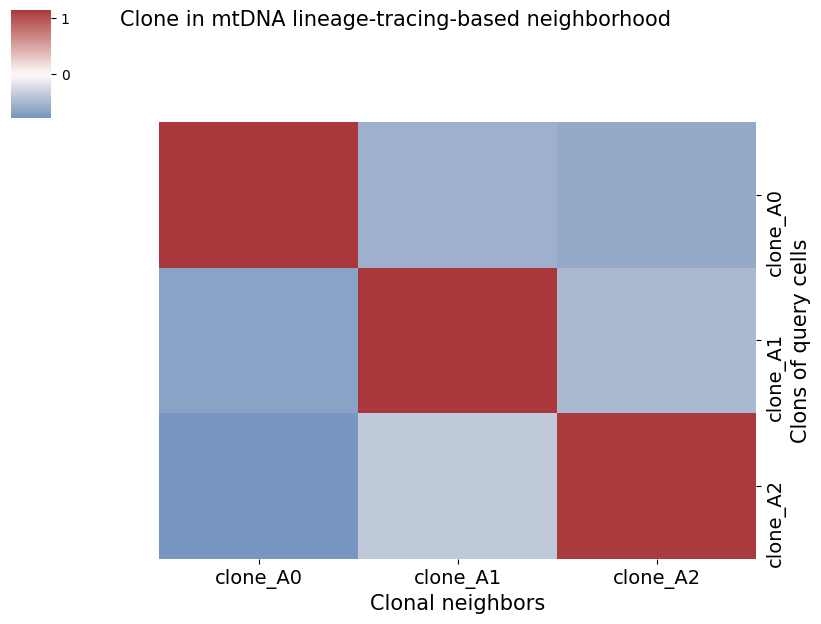

In [18]:
k_param=30
o_af_df = af_df.T
get_connectness(ps_map, clone_df.copy(), _OUTGROUP_ID, out_dir, k_param, clone_label_prefix)

In [19]:
# create Genotype + clone csv for loading in cell type annotation
out_dir = args.output_dir
af_o_df = pd.read_csv(out_dir + "/clone_af.csv", sep="\t", header=0,  index_col=0)
af_m = af_o_df.to_numpy(dtype=np.float64)

# parse barcode and snp name
af_cutoff = 0.02
af_m[af_m>=af_cutoff] = 1
af_m[af_m<af_cutoff] = 0

snp_id = ["%s%s>%s" % (tuple(i.split("_")[1:])) for i in af_o_df.index]

af_df = pd.DataFrame(af_m.T, columns=snp_id, dtype=np.float64)
af_columns = af_df.columns

af_columns_o = sorted(af_columns, key=lambda x:int(x[:-3]))

af_df['barcode'] = af_o_df.columns + "-1"
# af_df.head(2)

In [20]:
clone_df = pd.read_csv(out_dir + "/clone.csv")
clone_df['barcode'] = clone_df['barcode'] + "-1"

clone_af_all_df = pd.merge(af_df, clone_df, how='left')
clone_af_all_df.to_csv(out_dir + '/clone_af_all.csv', index=False)
clone_af_all_df.head(2)

c_o = sorted(clone_af_all_df['clone'].unique(), key=lambda x:int(x[len(clone_label_prefix):]))
# print(c_o)

In [21]:
_stack_df = clone_af_all_df[['clone'] + af_columns_o] .set_index('clone').stack().reset_index()
_stack_df = _stack_df[_stack_df[0] != 0][['level_1', 'clone']].rename(columns={'level_1': 'snp'})
stack_df = _stack_df.rename(columns={'snp':'layer1', 'clone':'layer2'})
stack_df = stack_df[["layer1", "layer2"]]
# stack_df
# stack_df

In [22]:
import logging
logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

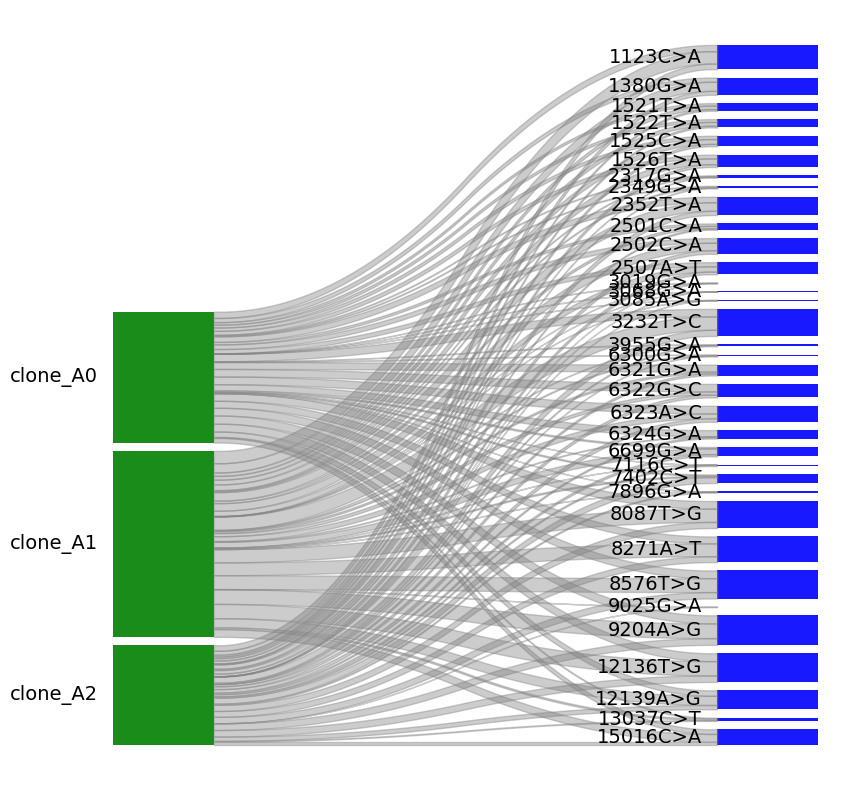

In [23]:
# !pip install git+https://github.com/SZJShuffle/pySankey2.git

from pysankey2.utils import setColorConf
from pysankey2 import Sankey
layer_labels= {'layer2':c_o[::-1], 'layer1':af_columns_o[::-1]}
sky = Sankey(stack_df,layerLabels = layer_labels, \
             colorMode="layer", colorDict={"layer1": {i:"blue" for i in af_columns_o}, \
                                           "layer2": {i:"green" for i in c_o}})
fig,ax = sky.plot()
# Adjust font size for all text elements
for text in ax.texts:
    text.set_fontsize(14)  # Set font size to 14 (adjust as needed)
fig.savefig(out_dir + "/s_1_clone_snp_sankey.png", bbox_inches='tight')

In [24]:
print(af_columns_o)

['1123C>A', '1380G>A', '1521T>A', '1522T>A', '1525C>A', '1526T>A', '2317G>A', '2349G>A', '2352T>A', '2501C>A', '2502C>A', '2507A>T', '3019G>A', '3068G>A', '3085A>G', '3232T>C', '3955G>A', '6300G>A', '6321G>A', '6322G>C', '6323A>C', '6324G>A', '6699G>A', '7116C>T', '7402C>T', '7896G>A', '8087T>G', '8271A>T', '8576T>G', '9025G>A', '9204A>G', '12136T>G', '12139A>G', '13037C>T', '15016C>A']


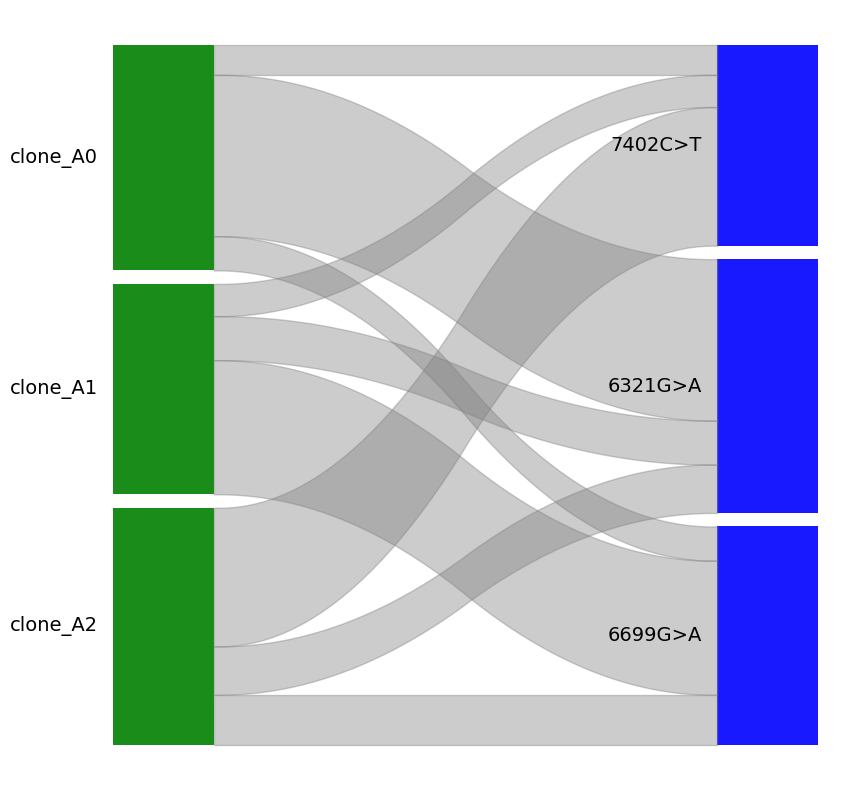

In [25]:
# target snp 
t_snp_lst = ['7402C>T', '6321G>A', '6699G>A']

# t_snp_lst = ['7402C>T', '4216C>T', '8628C>T']
tar_stack_df = stack_df[stack_df.layer1.isin(t_snp_lst)]

_c_o = sorted(tar_stack_df['layer2'].unique(), key=lambda x:int(x[len(clone_label_prefix):]))
layer_labels= {'layer2':_c_o[::-1], 'layer1':t_snp_lst[::-1]}
sky = Sankey(tar_stack_df,layerLabels = layer_labels, \
             colorMode="layer", colorDict={"layer1": {i:"blue" for i in t_snp_lst}, \
                                           "layer2": {i:"green" for i in _c_o}})
fig,ax = sky.plot()
# Adjust font size for all text elements
for text in ax.texts:
    text.set_fontsize(14)  # Set font size to 14 (adjust as needed)
fig.savefig(out_dir + "/s_1_clone_snp_sankey_tar.png", bbox_inches='tight')

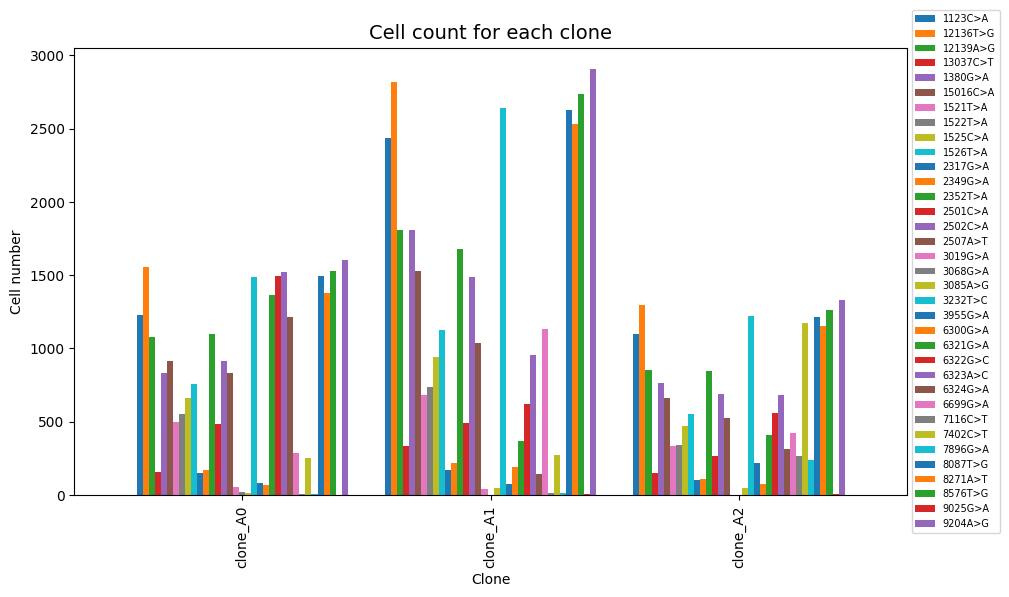

In [26]:
df = _stack_df.groupby(['clone', 'snp']).size()

df.unstack().plot.bar(figsize=(10,6), width=0.85)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 7})
plt.tight_layout()
plt.ylabel("Cell number")
plt.xlabel("Clone")
plt.title("Cell count for each clone", fontsize=14)
plt.savefig(out_dir + "/s_2_clone_snp_barplot.png", bbox_inches='tight')

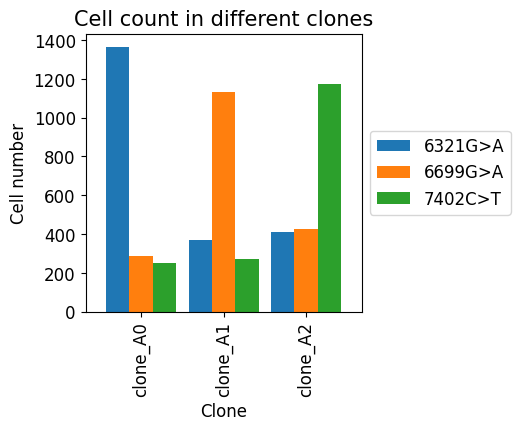

In [27]:
# t_snp_lst = ['7402C>T', '6321G>A', '6699G>A']
tar_stack_df = _stack_df[_stack_df.snp.isin(t_snp_lst)]

df = tar_stack_df.groupby(['clone', 'snp']).size()

df.unstack().plot.bar(figsize=(5,4), width=0.85)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 12})
plt.tight_layout()
plt.ylabel("SNP number", fontsize=12)
plt.xlabel("Clone", fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

plt.title("SNP count in different clones", fontsize=15)
plt.savefig(out_dir + "/s_2_clone_snp_barplot_tar.png", bbox_inches='tight')

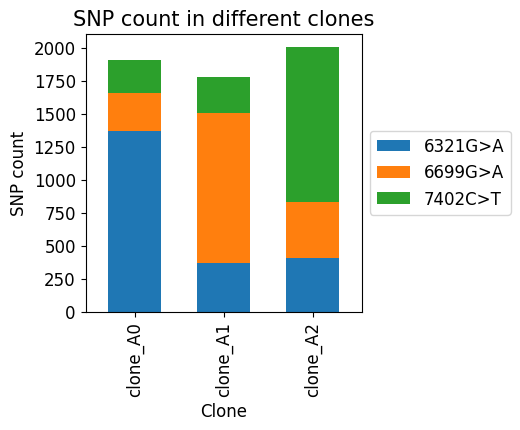

In [28]:
# t_snp_lst = ['7402C>T', '6321G>A', '6699G>A']
tar_stack_df = _stack_df[_stack_df.snp.isin(t_snp_lst)]

tar_stack_df.groupby(['clone', 'snp']).size().reset_index().pivot_table(index='clone', columns='snp', values=0).plot(kind='bar', stacked=True, 
                                                                                                                    figsize=(5,4), width=0.6)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 12})
plt.tight_layout()
plt.ylabel("SNP count", fontsize=12)
plt.xlabel("Clone", fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

plt.title("SNP count in different clones", fontsize=15)
plt.savefig(out_dir + "/s_2_clone_snp_barplot_tar.png", bbox_inches='tight')

In [185]:
# df.unstack()

In [29]:
# analysis clone with cell type, optional
# load cell type
ct_f = "/autofs/bal31/jhsu/home/projects/sc/data/hemo_paper_larry/larry-maester-d4/sc/2_bam/outs/cell_type_0310.csv"

cell_type = pd.read_csv(ct_f, header=0)

cell_type["ID"] = cell_type[["Unnamed: 0"]]
cell_type["annotation"] = cell_type['cell_type']
cell_type = cell_type[['ID', 'annotation']]

a_o = sorted(cell_type['annotation'].unique())

cell_type.shape, cell_type.head(3)

((4682, 2),
                    ID annotation
 0  AAACCCACAAGACCTT-1   Mes-like
 1  AAACCCACATCGCTGG-1    TB-like
 2  AAACCCAGTCAGGTAG-1    TB-like)

In [30]:
# clone_af_all_df

In [31]:
# clone and cell type
n_tar_df = pd.merge(clone_af_all_df, cell_type, left_on = "barcode", right_on = "ID", how='inner')

In [32]:
# clone_af_all_df

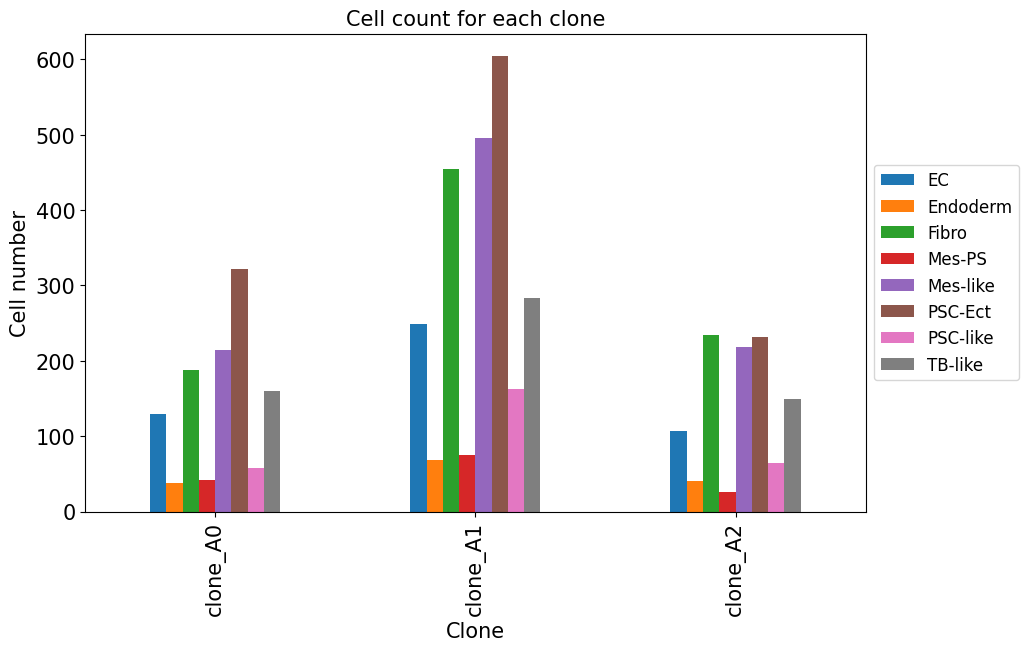

In [33]:
_tmp_tar1, _tmp_tar2 = "clone", "annotation"
df = n_tar_df.groupby([_tmp_tar1, _tmp_tar2]).size()
df.unstack().plot.bar(figsize=(10,6))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 12})
plt.tight_layout()
plt.ylabel("Cell number", fontsize=15)
plt.xlabel("Clone", fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.title("Cell count for each clone", fontsize=15)
plt.savefig(out_dir + "/s_3_clone_celltype_barplot.png", bbox_inches='tight')

In [34]:
# df.unstack()

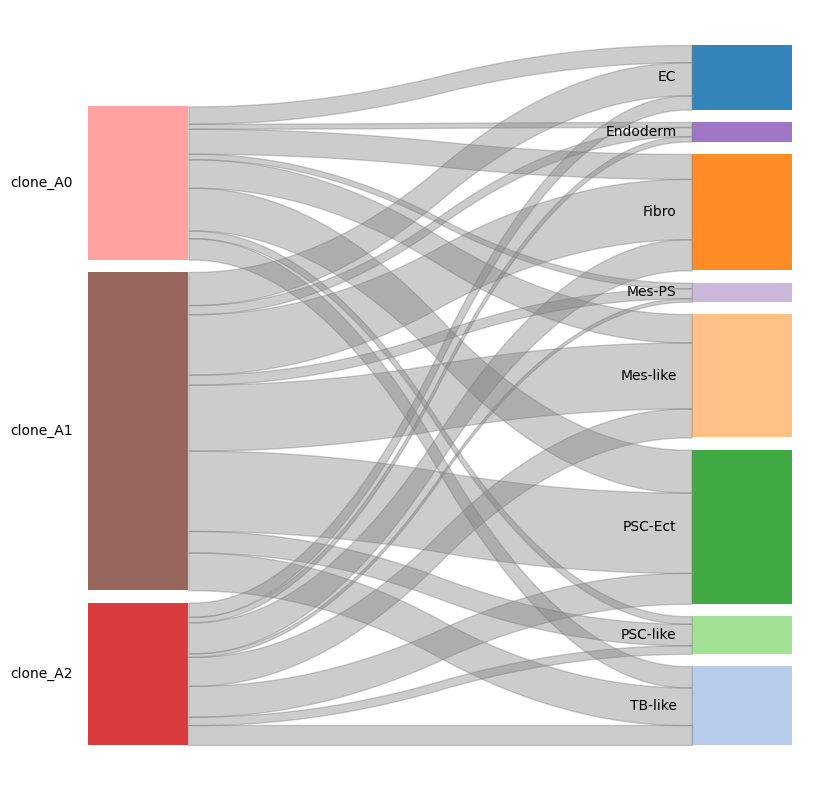

In [35]:
# !pip install git+https://github.com/SZJShuffle/pySankey2.git
from pysankey2.utils import setColorConf
from pysankey2 import Sankey
tmp_tar_df = n_tar_df[[_tmp_tar1, _tmp_tar2]]
tmp_tar_df = tmp_tar_df.rename(columns={_tmp_tar1:'layer1', _tmp_tar2:'layer2'})

layer_labels= {'layer1':c_o[::-1],'layer2':a_o[::-1]}
sky = Sankey(tmp_tar_df,colorMode="global", layerLabels = layer_labels)
fig,ax = sky.plot()
fig.savefig(out_dir + "/s_5_clone_celltype_sankey.png", bbox_inches='tight')

/tmp/ipykernel_2016772/2086557571.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  raw_col = cm.get_cmap('Blues', 200)


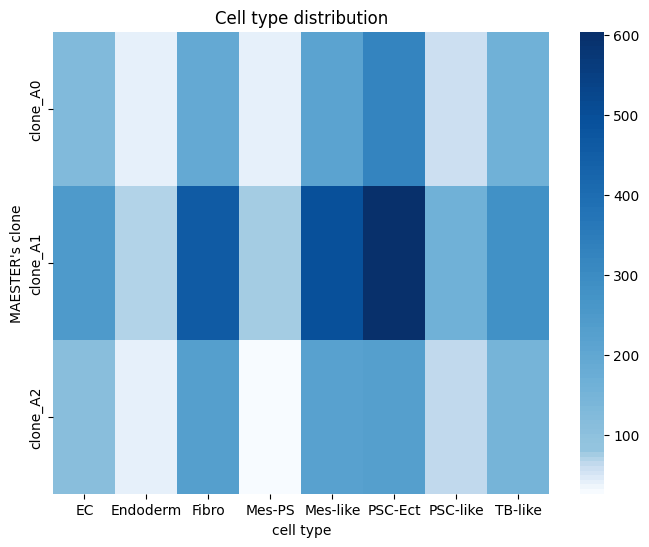

In [36]:
# _tmp_tar1, _tmp_tar2 = 'mclone', 'annotation'
tmp_tar_df = n_tar_df[['barcode', _tmp_tar1, _tmp_tar2]]
n_tmp_df = tmp_tar_df.groupby([_tmp_tar1, _tmp_tar2]).size().reset_index(name='counts')
n_tmp_df

# Pivot the DataFrame to get the format needed for a heatmap
heatmap_data = n_tmp_df.pivot_table(index=_tmp_tar1, columns=_tmp_tar2, values='counts', fill_value=0)
# heatmap_data

from scipy.cluster.hierarchy import linkage, leaves_list

# Perform hierarchical clustering on the rows
linkage_matrix = linkage(heatmap_data, method='average')
dendro_order = leaves_list(linkage_matrix)

# Reorder the DataFrame based on clustering
ordered_heatmap_data = heatmap_data.iloc[dendro_order]


ordered_heatmap_data = ordered_heatmap_data.reindex(c_o)

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

_af_cf = 0.4
raw_col = cm.get_cmap('Blues', 200)
new_col = np.vstack((raw_col(np.linspace(0, _af_cf, 10)), raw_col(np.linspace(_af_cf, 1, 90))))
_cmap = ListedColormap(new_col)


plt.figure(figsize=(8,6))
# ax = sns.heatmap(ordered_heatmap_data, cmap="Blues", yticklabels=[],cmap=_cmap,  )
ax = sns.heatmap(ordered_heatmap_data,  cmap=_cmap,  )
plt.xlabel("cell type")
plt.ylabel("MAESTER's clone")
plt.title("Cell type distribution")

plt.savefig(out_dir + "/s_6_clone_celltype_heatmap.png", bbox_inches='tight')

In [37]:
# tar_merge

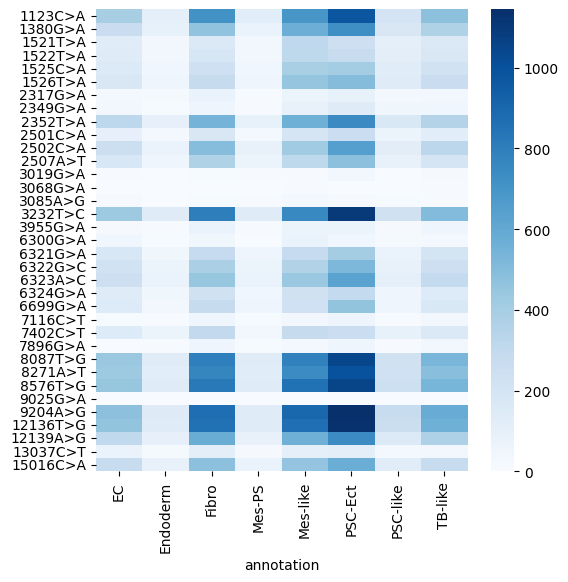

In [38]:
# snp and cell type
tar_merge = n_tar_df.groupby('annotation').agg({i: 'sum' for i in af_columns})
tar_merge = tar_merge[af_columns_o]


plt.figure(figsize = (6,6))
ax = sns.heatmap(tar_merge.T, cmap="Blues", xticklabels=True, yticklabels=True)
plt.savefig(out_dir + "/s_7_snp_celltype_heatmap.png", bbox_inches='tight')

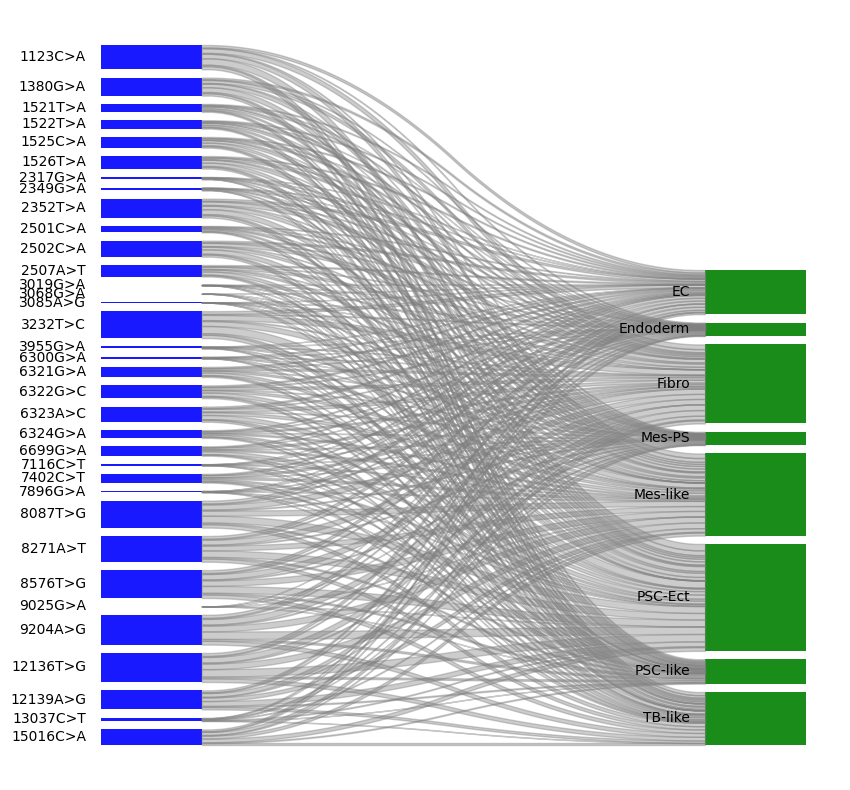

In [39]:
stack_df = n_tar_df[['annotation'] + af_columns_o].set_index('annotation').stack().reset_index()
stack_df = stack_df[stack_df[0] != 0][['level_1', 'annotation']].rename(columns={'level_1': 'snp'})
stack_df = stack_df.rename(columns={'snp':'layer1', 'annotation':'layer2'})
stack_df.head()

# !pip install git+https://github.com/SZJShuffle/pySankey2.git
from pysankey2.utils import setColorConf
from pysankey2 import Sankey
# tmp_tar_df = n_tar_df[[_tmp_tar1, _tmp_tar2]]
layer_labels= {'layer1':af_columns_o[::-1],'layer2':a_o[::-1]}
sky = Sankey(stack_df,layerLabels = layer_labels, \
             colorMode="layer", colorDict={"layer1": {i:"blue" for i in af_columns_o}, \
                                           "layer2": {i:"green" for i in a_o}})
fig,ax = sky.plot()
fig.savefig(out_dir + "/s_8_snp_celltype_sankey.png", bbox_inches='tight')

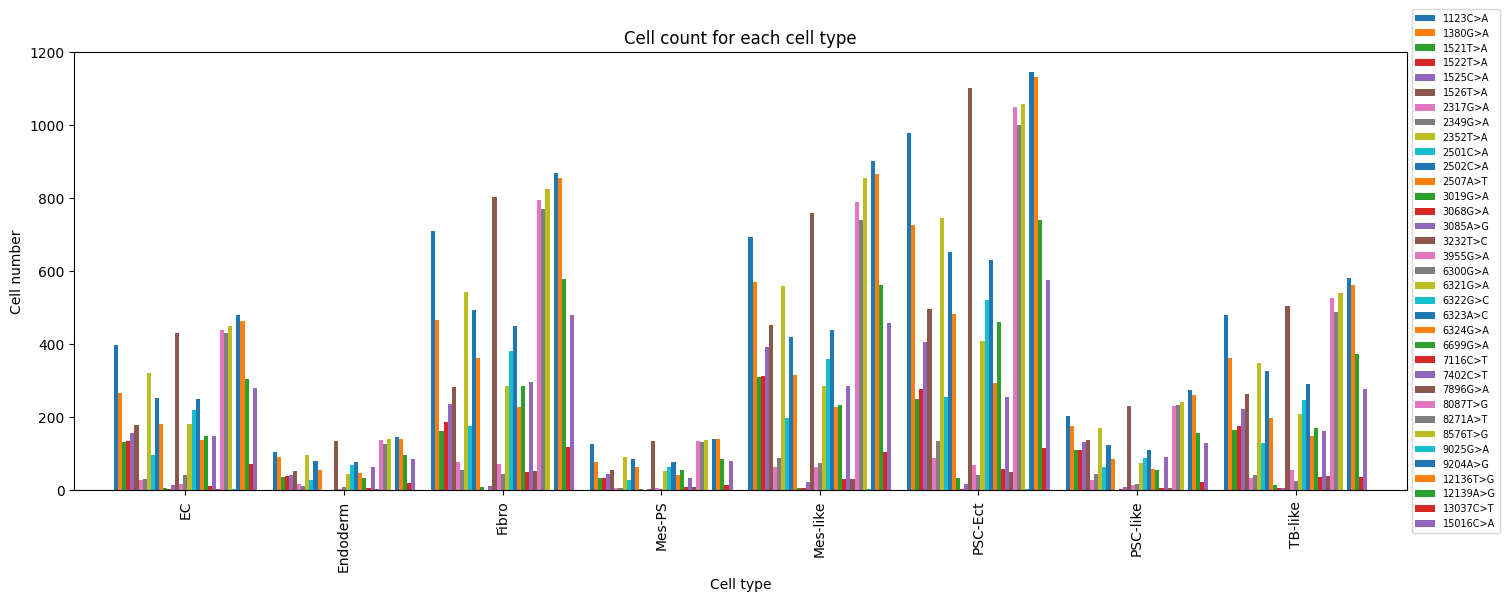

In [40]:
tar_merge.plot.bar(figsize=(15,6), width=0.9)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 7})
plt.tight_layout()
plt.ylabel("Cell number")
plt.xlabel("Cell type")
plt.title("Cell count for each cell type")
plt.savefig(out_dir + "/s_9_snp_celltype_barplot.png", bbox_inches='tight')